In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sqlite3
# import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
# %config InlineBackend.figure_formats = ['svg']
from IPython.display import GeoJSON

In [2]:
df = pd.read_csv('Collisions.csv', parse_dates=['INCDTTM'])
df.head(5)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.263950,47.506127,2001,328656,330156,3857179,Unmatched,Block,NaN,S BANGOR ST BETWEEN 55TH AVE S AND 56TH AVE S,,NaN,2,Injury Collision,NaN,2,0,0,0,1,0,0,2020-02-08T00:00:00.000Z,2020-02-08,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
1,-122.386116,47.561089,2002,328162,329662,3856099,Unmatched,Block,NaN,SW ALASKA ST BETWEEN 42ND AVE SW AND CALIFORNI...,,NaN,1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2020-01-21T00:00:00.000Z,2020-01-21,Mid-Block (not related to intersection),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
2,-122.351134,47.570942,2003,327702,329202,3856190,Unmatched,Block,NaN,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,,NaN,1,Property Damage Only Collision,NaN,1,0,0,0,0,0,0,2020-01-10T00:00:00.000Z,2020-01-10,Mid-Block (not related to intersection),26.0,MOTOR VEHICLE STRUCK OBJECT IN ROAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
3,-122.336648,47.613376,2004,328744,330244,EA13303,Unmatched,Block,NaN,6TH AVE BETWEEN OLIVE WAY AND STEWART ST,,NaN,1,Property Damage Only Collision,NaN,4,0,0,0,0,0,0,2020-02-06T00:00:00.000Z,2020-02-06,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
4,-122.326715,47.661352,2005,328102,329602,EA06204,Unmatched,Block,NaN,NE 45TH ST BETWEEN 2ND AVE NE AND THACKERAY PL NE,,NaN,1,Property Damage Only Collision,NaN,3,0,0,0,0,0,0,2020-01-17T00:00:00.000Z,2020-01-17,Mid-Block (but intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


# Re-labeling serverity

In [3]:
df['SEVERITYCODE'] = df['SEVERITYCODE'].map({'0': 'Unknown', '1': 'Prop_damage', '2': 'Injury', '2b': 'Serious_injury', '3': 'Fatality'})

In [4]:
df.groupby(['SEVERITYCODE']).size().to_frame('count')

,count
SEVERITYCODE,
Fatality,341
Injury,57756
Prop_damage,135545
Serious_injury,3029
Unknown,21239


# Overview of the dataset

In [5]:
df.shape

(217911, 40)

In [6]:
df.dtypes

X                         float64
Y                         float64
OBJECTID                    int64
INCKEY                      int64
COLDETKEY                   int64
REPORTNO                   object
STATUS                     object
ADDRTYPE                   object
INTKEY                    float64
LOCATION                   object
EXCEPTRSNCODE              object
EXCEPTRSNDESC              object
SEVERITYCODE               object
SEVERITYDESC               object
COLLISIONTYPE              object
PERSONCOUNT                 int64
PEDCOUNT                    int64
PEDCYLCOUNT                 int64
VEHCOUNT                    int64
INJURIES                    int64
SERIOUSINJURIES             int64
FATALITIES                  int64
INCDATE                    object
INCDTTM            datetime64[ns]
JUNCTIONTYPE               object
SDOT_COLCODE              float64
SDOT_COLDESC               object
INATTENTIONIND             object
UNDERINFL                  object
WEATHER       

In [7]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

# Take a look at some of the categorial columns

In [8]:
df['year'] = pd.DatetimeIndex(df.INCDTTM).year

In [39]:
yeardf = df.groupby('year').year.size().to_frame('INCKEY').reset_index()
yeardf = yeardf[yeardf.INCKEY > 1]
#I dropped year 2003 which only had 1 incident in the dataset
yeardf.head(20)

,year,INCKEY
1,2004,15457
2,2005,16016
3,2006,15794
4,2007,15082
5,2008,14139
6,2009,13275
7,2010,11958
8,2011,12416
9,2012,12732
10,2013,12757


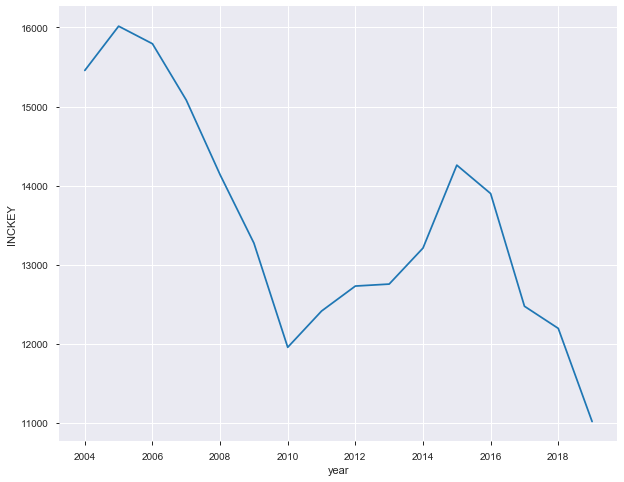

In [40]:
yeardf = yeardf[(yeardf['year'] < 2020)]
fig = plt.figure(figsize=(10, 8))
sns.lineplot(x="year", y="INCKEY", data=yeardf)


In [10]:
df[['REPORTNO', 'STATUS',
       'ADDRTYPE', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'HITPARKEDCAR']].nunique()

REPORTNO          217908
STATUS                 2
ADDRTYPE               3
LOCATION           25051
EXCEPTRSNCODE          2
EXCEPTRSNDESC          1
SEVERITYCODE           5
SEVERITYDESC           5
COLLISIONTYPE         10
INCDATE             5901
INCDTTM           165392
JUNCTIONTYPE           7
SDOT_COLDESC          39
INATTENTIONIND         1
UNDERINFL              4
WEATHER               10
ROADCOND               9
LIGHTCOND              8
PEDROWNOTGRNT          1
SPEEDING               1
ST_COLCODE            63
ST_COLDESC            62
HITPARKEDCAR           2
dtype: int64

In [11]:
status = list(df['STATUS'].unique())
status

['Unmatched', 'Matched']

Note: Not sure what 'matched' means

In [12]:
addrtype = list(df['ADDRTYPE'].unique())
addrtype

['Block', 'Intersection', 'Alley', nan]

In [13]:
location = list(df['LOCATION'].unique())
location[:10]

['S BANGOR ST BETWEEN 55TH AVE S AND 56TH AVE S',
 'SW ALASKA ST BETWEEN 42ND AVE SW AND CALIFORNIA AVE SW',
 'WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP',
 '6TH AVE BETWEEN OLIVE WAY AND STEWART ST',
 'NE 45TH ST BETWEEN 2ND AVE NE AND THACKERAY PL NE',
 '6TH AVE AND DENNY WAY',
 '39TH AVE S BETWEEN S OTHELLO ST AND S HOLLY PARK DR',
 '22ND AVE NW AND SHILSHOLE AVE NW',
 'FAIRVIEW AVE N AND MERCER ST',
 '9TH AVE BETWEEN SPRING ST AND SENECA ST']

In [14]:
collisiontype = list(df['COLLISIONTYPE'].unique())
collisiontype

[nan,
 'Rear Ended',
 'Sideswipe',
 'Parked Car',
 'Angles',
 'Other',
 'Cycles',
 'Left Turn',
 'Pedestrian',
 'Right Turn',
 'Head On']

In [15]:
junctiontype = list(df['JUNCTIONTYPE'].unique())
junctiontype

['Mid-Block (not related to intersection)',
 'Mid-Block (but intersection related)',
 'At Intersection (intersection related)',
 nan,
 'Driveway Junction',
 'At Intersection (but not related to intersection)',
 'Ramp Junction',
 'Unknown']

In [16]:
adddf = df.groupby('ADDRTYPE').size().to_frame('INCKEY').reset_index()
adddf.head()

,ADDRTYPE,INCKEY
0,Alley,856
1,Block,142758
2,Intersection,70621


# Incidents by type of location

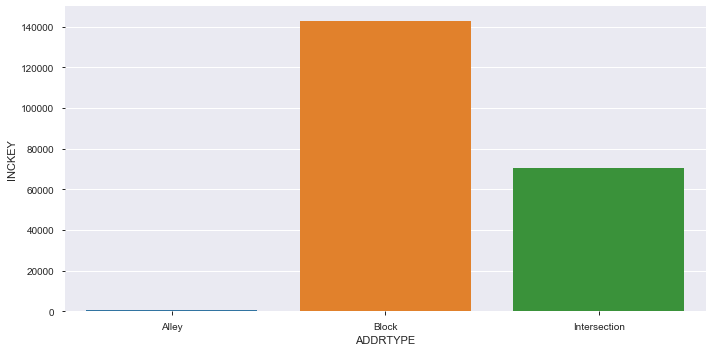

In [17]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= adddf, x= 'ADDRTYPE', y= 'INCKEY')

plt.tight_layout()

# Incidents by type of collision

In [18]:
colldf = df.groupby('COLLISIONTYPE').size().to_frame('INCKEY').reset_index()
colldf.head()

,COLLISIONTYPE,INCKEY
0,Angles,34664
1,Cycles,5802
2,Head On,2122
3,Left Turn,13837
4,Other,24027


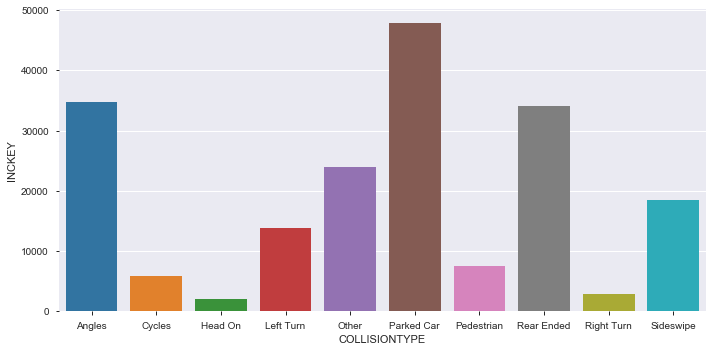

In [19]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= colldf, x= 'COLLISIONTYPE', y= 'INCKEY')

plt.tight_layout()

# Incidents by severity

In [20]:
scdf = df.groupby('SEVERITYCODE').size().to_frame('Count').reset_index()
scdf.head()

,SEVERITYCODE,Count
0,Fatality,341
1,Injury,57756
2,Prop_damage,135545
3,Serious_injury,3029
4,Unknown,21239


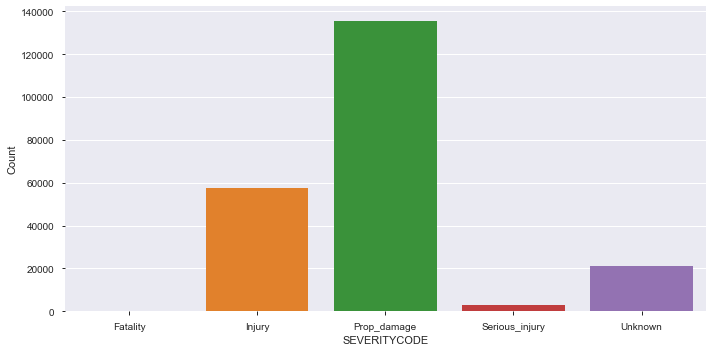

In [21]:
fig = plt.figure(figsize=(10, 5))

chart = sns.barplot(data= scdf, x= 'SEVERITYCODE', y= 'Count')

plt.tight_layout()

Note: SEVERITYCODE and SEVERITYDESC have the same information


# Severity by type of collision

In [22]:
type_severity = df.groupby(['COLLISIONTYPE', 'SEVERITYCODE'])['INCKEY'].count().reset_index()
type_severity_pivot = type_severity.pivot(
    columns = 'SEVERITYCODE',
    index = 'COLLISIONTYPE',
    values = 'INCKEY').reset_index()
type_severity_pivot

SEVERITYCODE,COLLISIONTYPE,Fatality,Injury,Prop_damage,Serious_injury,Unknown
0,Angles,24.0,13453.0,20754.0,432.0,1.0
1,Cycles,25.0,4695.0,667.0,415.0,NaN
2,Head On,20.0,862.0,1139.0,101.0,NaN
3,Left Turn,16.0,5346.0,8207.0,268.0,NaN
4,Other,91.0,6047.0,17400.0,489.0,NaN
5,Parked Car,7.0,2629.0,45054.0,125.0,NaN
6,Pedestrian,125.0,5839.0,658.0,834.0,NaN
7,Rear Ended,11.0,14564.0,19202.0,222.0,NaN
8,Right Turn,1.0,602.0,2327.0,20.0,NaN
9,Sideswipe,10.0,2474.0,15926.0,71.0,NaN


# Which locations have had high numbers of incidents?

In [23]:
locdf = df.groupby('LOCATION').size().to_frame('INCKEY').reset_index()
locdf.sort_values('INCKEY', ascending=False, inplace=True)
locdf.head(10)

,LOCATION,INCKEY
11241,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,298
17512,N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND COR...,294
11242,BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ...,291
11075,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,278
9543,6TH AVE AND JAMES ST,270
11079,AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,264
10774,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,256
20135,RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLE...,254
10786,ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND...,230
24688,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,224


# Which locations have the highest numbers of fatal and serious injuries?

In [24]:
sevdf = df[(df['SEVERITYCODE'] == ('Fatality' or 'Serious_injury'))]
sevcdf = sevdf.groupby('LOCATION').size().to_frame('INCKEY').reset_index()
sevcdf.sort_values('INCKEY', ascending=False, inplace=True)
sevcdf.head(10)

,LOCATION,INCKEY
126,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,4
128,ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND...,4
217,M L KING JR ER WAY S BETWEEN S DIRECTOR ST AND...,3
308,WESTLAKE AVE N BETWEEN HALLADAY ST AND NEWELL ST,3
127,ALASKAN WY VI SB BETWEEN ALASKAN WY VI SB EFR ...,3
141,AURORA AVE N BETWEEN GARFIELD ST AND HOWE ST,3
71,35TH AVE SW AND SW GRAHAM ST,2
257,RAINIER AVE S BETWEEN S MOUNT BAKER EB BV AND ...,2
263,ROOSEVELT WAY NE AND NE 65TH ST,2
144,AURORA AVE N BETWEEN HOWE ST AND LYNN ST,2


Note: Locations that have the highest numbers of incidents and locations that have more severe incidetns don't overlap a lot